In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [10]:
file_path = '../Features/Large/selected_features_RF_voting2.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,SlogP_VSA2,TPSA,EState_VSA3,VSA_EState5,VSA_EState7,VSA_EState8,NOCount,MolLogP,MolMR,Irritation
0,0.545511,0.545511,0.223433,0.490223,0.231801,0.390551,0.291325,0.304410,0.289616,0.250000,...,0.085917,0.338751,0.396236,0.424656,0.612293,0.288096,0.375,0.451534,0.256965,0
1,0.591920,0.591920,0.253125,0.601726,0.300830,0.389406,0.277681,0.277787,0.276841,0.278846,...,0.223271,0.206517,0.417024,0.669085,0.612293,0.362290,0.250,0.416318,0.289955,1
2,0.553126,0.553126,0.334919,0.502072,0.216293,0.400859,0.399452,0.416364,0.396549,0.278846,...,0.085917,0.338751,0.000000,0.424656,0.612293,0.288096,0.375,0.475805,0.308357,1
3,0.612445,0.612445,0.602032,0.496240,0.289320,0.408749,0.461148,0.456542,0.459507,0.423077,...,0.393555,0.300982,0.584450,0.697651,0.780786,0.510760,0.375,0.560347,0.467691,0
4,0.618170,0.618170,0.914475,0.141109,0.058745,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001067,0.000000,0.000000,0.424656,0.612293,0.000000,0.000,0.225586,0.000000,0


In [11]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1989, 47)
Shape of X_test: (498, 47)
Shape of y_train: (1989,)
Shape of y_test: (498,)


In [13]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # Define hyperparameter search space with stronger regularization
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=50),  # Reduce tree count
        "max_depth": trial.suggest_int("max_depth", 3, 8),  # Smaller trees
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50, step=5),  # Avoid small splits
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20, step=5),  # Larger leaves
        "max_features": trial.suggest_categorical("max_features", ["sqrt"]),  # Always sqrt for simplicity
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),  # Force bootstrap
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.8)  # Reduce data seen per tree
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = RandomForestClassifier(**param, random_state=42)
        model.fit(X_train_cv, y_train_cv)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    # Return mean validation accuracy
    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)


[I 2025-03-09 15:33:41,788] A new study created in memory with name: no-name-261d1812-5e38-42d8-8ffb-b143a4fe9bd5


[I 2025-03-09 15:33:45,099] Trial 0 finished with value: 0.7048896877333772 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6203489070363443}. Best is trial 0 with value: 0.7048896877333772.
[I 2025-03-09 15:33:47,424] Trial 1 finished with value: 0.6953381517157575 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7541161584969096}. Best is trial 0 with value: 0.7048896877333772.
[I 2025-03-09 15:33:49,466] Trial 2 finished with value: 0.7109261673607331 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6931128574749936}. Best is trial 2 with value: 0.7109261673607331.
[I 2025-03-09 15:33:51,863] Trial 3 finished with value: 0.6983519613179245 and par

Best trial: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 35, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7987355391529141}


Final Model Accuracy: 0.7590361445783133


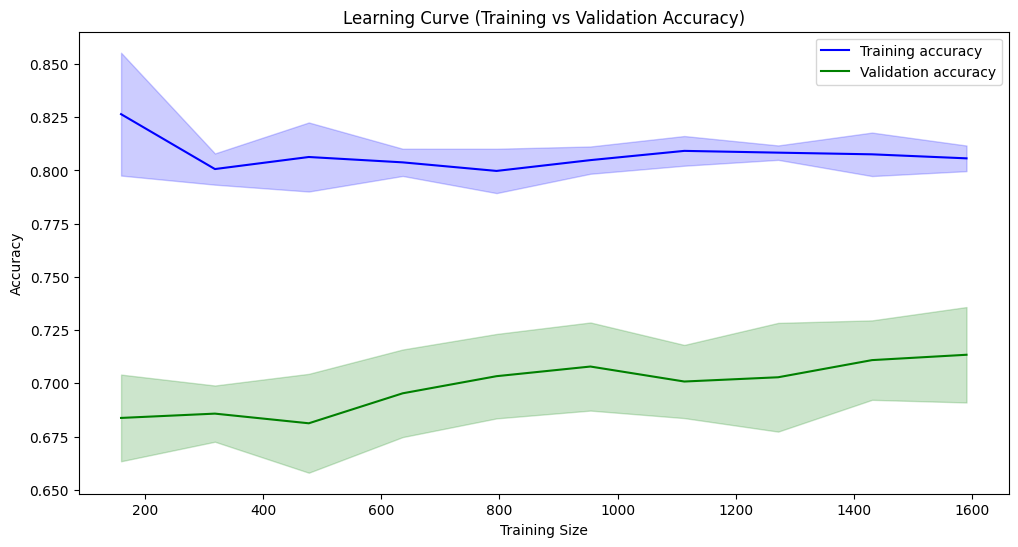

Train Accuracy: 0.8094519859225742
Test Accuracy: 0.7590361445783133


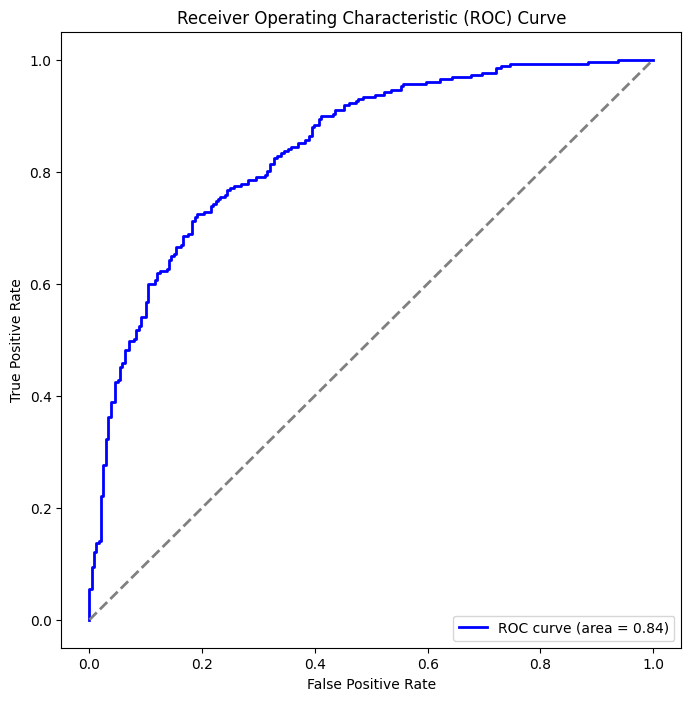

In [14]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
# Get best hyperparameters from study (assuming Optuna tuning)
best_params = study.best_trial.params

# Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))

# 1. Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 2. ROC Curve Plot
# Calculate ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])  # Get probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [15]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

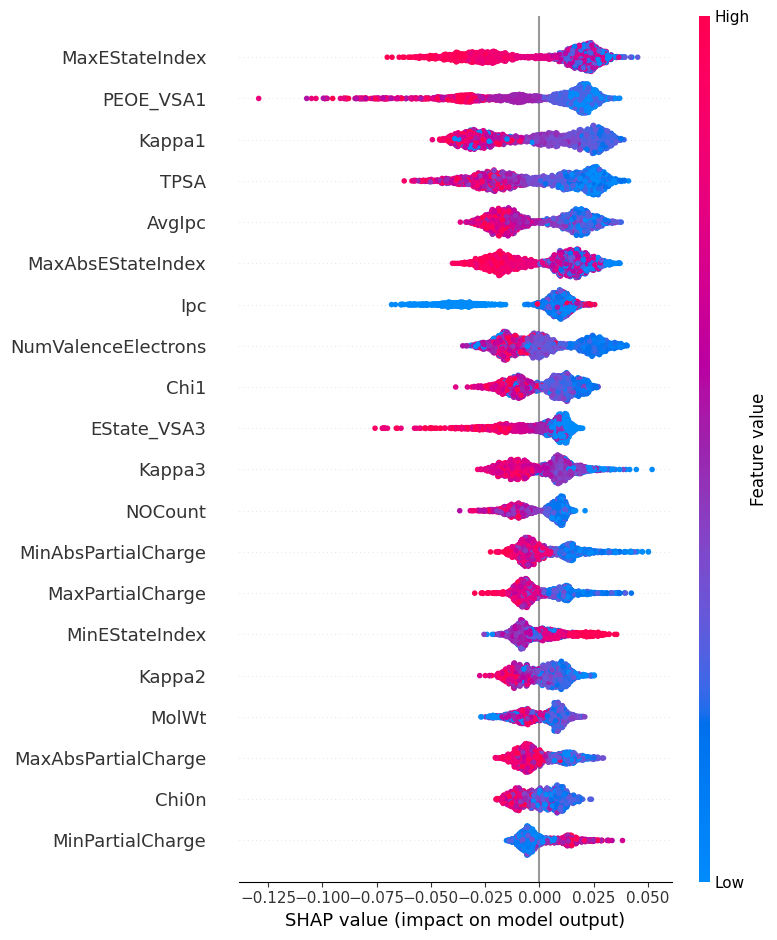

In [16]:
shap.summary_plot(shap_values[:,:,1], X_train)

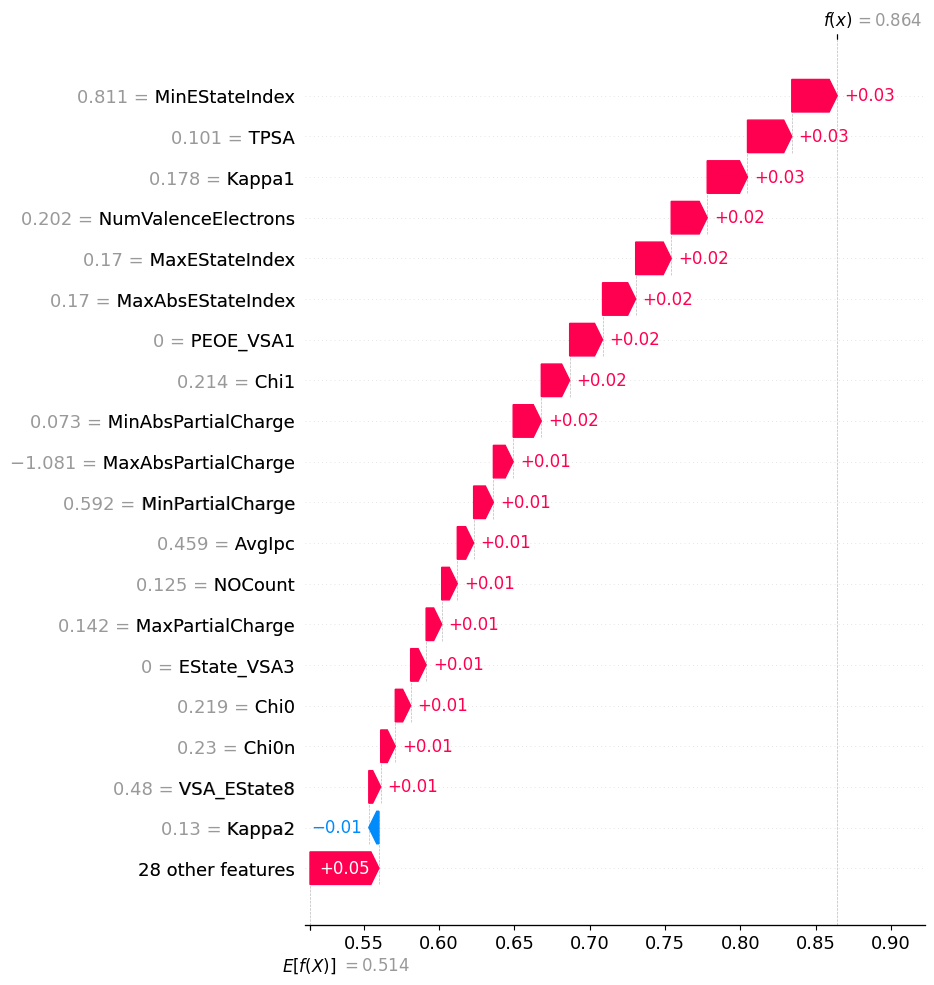

In [17]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [18]:
print(final_model.get_params())  # Replace "XGBoost" with any model name

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.7987355391529141, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 35, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [22]:

important_hyperparams = [
    "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
    "max_features", "bootstrap", "criterion", "oob_score",
    "random_state", "class_weight"
]

rf_hyperparams = {param: final_model.get_params()[param] for param in important_hyperparams}
rf_hyperparams

{'n_estimators': 50,
 'max_depth': 8,
 'min_samples_split': 35,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'bootstrap': True,
 'criterion': 'gini',
 'oob_score': False,
 'random_state': None,
 'class_weight': None}

In [9]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'rf_model.pkl')

print("Model saved successfully!")


Model saved successfully!
